## Latent Dirichlet Allocation for Topic Modelling

Latent Dirichlet Allocation (LDA) aims to extract topics from a given corpus. LDA assumes that each document is a mixture of topics and that each topic is a mixture of words.

The model uses Bayesian inference to update the prior knowledge of the distribution of the topics.

We produce a document-word matrix (bag of words).

First we import the necessary packages.

In [1]:
import pandas as pd
import pickle
import numpy as np
np.random.seed(2018)
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim import corpora
from pprint import pprint
import gensim.models

We then load the cleaned dataset into a dataframe.

In [2]:
trainingDf = pd.read_csv('data_cleaned_full_text_and_summariesD.csv')

Due to issues with data formatting from the preprocessing, the 'text' and 'combine' columns contain the same information, however the 'text' column contains a list of the string word tokens, whereas 'combine' contains a string for each document. Below we assign docs to be just the 'combine' column.

In [7]:
def myprocess(thisdoc):
    ## Runs on documents (vector of words)
    return(thisdoc.strip('[]').replace("'", ' ').replace("u ", '').replace(' ', '').split(','))

In [8]:
docs=trainingDf['text'].map(myprocess) 
docs[1]

['return',
 'leave',
 'scratch',
 'head',
 'first',
 'chapter',
 'screenshots',
 'not',
 'even',
 'match',
 'text',
 'page',
 'author',
 'reviewer',
 'any',
 'publisher',
 'editor',
 'ashamed',
 'never',
 'see',
 'book',
 'unsuitable',
 'publication',
 'hope',
 'author',
 'review',
 'work',
 'future']

In order to improve the performance we wanted to explore encoding the meaning of phrases which as seperate words may have essentially opposite meaning, this is called negation detection. For example, a review containing the word "good" should be categorised as negative if it happens to have the word "not" before it. this exploration is detailed in the notebook 05-Investiagting-Ngrams-LDA.ipynb. The results from this exploration showed that the methods we tried did not improve the performance, hence we decided not to pursue this further.

Below we implement the concept of a dictionary, by mapping words to their integer ids. We then filter out any tokens (words) which have frequency less than 5. The no_above parameter removes tokens appearing in more than 50% of documents will be removed. This is because words appearing in less than 5 documents will not help form topics, nor will words that occur very frequently (e.g. book).

In [9]:
dict_LoS = corpora.Dictionary(docs)

In [10]:
dict_LoS.filter_extremes(no_below=5, no_above=0.5)

Below we inspect the local directory to try to find the pickle file in order to load it. If the pickle file does not exist there then we create the bag of words corpus for the first time and save this as a pickle. We chose to use pickle over CSV because using pickles was faster when compared to CSV files and has the ability to reduce the file size to almost half of CSV files using its compression techniques.

In [12]:
# bag of words
try:
    print("Reading corpus from pickle")
    bow_corpus=pickle.load(open('bow_corpus.pkl', 'rb'))
except FileNotFoundError:
    print("Creating corpus and saving to pickle")
    bow_corpus = [dict_LoS.doc2bow(w) for w in docs]
    pickle.dump(bow_corpus, open('bow_corpus.pkl', 'wb'))
    pickle.dump(dict_LoS, open('dictionary.pkl', 'wb'))

Reading corpus from pickle
Creating corpus and saving to pickle


Here we perform a similar step, by checking whether the LDA model has already been created and saved as a pickle file. We chose the default number of topics to be 15, and instructed the model to pass over the entire corpus only once for time purposes. We choose to increase the size of the dataset we would train and tune on instead.

In [14]:
# LDA model
try:
    lda_model=pickle.load(open('lda_model.pkl', 'rb'))
    print("Reading lda_model from pickle")
except FileNotFoundError:
    print("Creating lda_model and saving to pickle")
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dict_LoS, passes=1, workers=2)
    pickle.dump(lda_model,open('lda_model.pkl','wb'))

Creating lda_model and saving to pickle


In [15]:
lda_model.show_topics(10,7)

[(7,
  '0.013*"one" + 0.008*"like" + 0.007*"make" + 0.007*"get" + 0.006*"story" + 0.006*"work" + 0.005*"well"'),
 (3,
  '0.011*"great" + 0.010*"good" + 0.009*"use" + 0.008*"one" + 0.008*"get" + 0.007*"make" + 0.006*"would"'),
 (9,
  '0.021*"story" + 0.014*"character" + 0.011*"one" + 0.011*"novel" + 0.009*"great" + 0.007*"first" + 0.006*"like"'),
 (0,
  '0.011*"life" + 0.008*"one" + 0.007*"people" + 0.007*"child" + 0.006*"way" + 0.006*"family" + 0.005*"make"'),
 (12,
  '0.009*"one" + 0.009*"life" + 0.008*"like" + 0.007*"time" + 0.007*"would" + 0.006*"war" + 0.006*"love"'),
 (14,
  '0.009*"life" + 0.007*"write" + 0.006*"like" + 0.006*"one" + 0.006*"great" + 0.005*"story" + 0.005*"well"'),
 (2,
  '0.047*"quot" + 0.009*"one" + 0.007*"work" + 0.005*"history" + 0.005*"the" + 0.005*"write" + 0.004*"also"'),
 (11,
  '0.010*"write" + 0.008*"one" + 0.008*"reader" + 0.007*"novel" + 0.005*"the" + 0.005*"story" + 0.005*"world"'),
 (8,
  '0.010*"one" + 0.007*"well" + 0.007*"world" + 0.006*"end" + 0.

# Evaluation of Initial Model

Coherence and perplexity are two types of metrics which can be used to evaluate topic models. 
Coherence represents how human interpretable the topics are, whereas perplexity represents how probable some new unseen data is given the model that was learned earlier. Ideally, we would like high coherence and low perplexity.

For coherence, we chose the C_v measure which is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity [[Evaluating LDA Topic Models](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=But%20before%20that%E2%80%A6-,What%20is%20topic%20coherence%3F,are%20artifacts%20of%20statistical%20inference)].




In [16]:
from gensim.models import CoherenceModel

In [17]:
# Compute Coherence Score function
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dict_LoS, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [18]:
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.30486856121774025


In [19]:
import math

In [20]:
# Compute perplexity score on the whole corpus
print('\nPerplexity: ', math.exp(lda_model.log_perplexity(bow_corpus)))


Perplexity:  0.0002762350202629195


## Hyperparameter tuning

Now we have established a baseline evaluation for our model, we can adjust the hyperparameters to try and optimise the perplexity score.

The key hyperparameters for our LDA model are:

* Number of Topics (K)
* Dirichlet hyperparameter alpha: Document-Topic Density
* Dirichlet hyperparameter beta: Word-Topic Density

Number of topics
Determining the number of topics for an LDA topic modelling alogirthm is important as too few topics may not capture the relationships well between the words, whereas too many topics may produce 'rubbish'. This is similar to under and overfitting respectively.


Aside from the number of topics, the most important parameters are the Bayesian prior hyperparameters alpha and beta (labelled ‘eta’ in Gensim). Both hyperparameters represent our prior beliefs about the corpus before we train our model.

Due to time and resource constraints, we decided to only explore the number of topics hyperparameter.

To determine the number topics, we shall create our own grid search algorithm which iterates through each point in the search space and calculates the perplexity score. We are aiming to minimise our perplexity score, however, we will use the elbow method when plotting the number of topics (k) against the perplexity to select the optimal k. This will hopefully prevent our model from overfitting.

In [21]:
# this is our supporting function for computing perplexity
def compute_perplexity_values(k):
    
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=k, id2word=dict_LoS, passes=2, workers=2)
    
    perplexity_model_lda = math.exp(lda_model.log_perplexity(bow_corpus))
    
    return perplexity_model_lda

Here we include a progress bar so the user can see how long the grid search has left.

In [22]:
import tqdm

We iterate over a range of topic numbers, from 10 to 30, with step size 2. The next chunk of code may take a while to run and should ideally be ran on a HPC. The model results are then outputted to a dataframe and plotted. The plot is saved to an external file.

In [28]:
min_topics=10
max_topics=11
step =1

topics_range = range(min_topics, max_topics+1, step)

model_results = {'Topics': [],
                 'Perplexity': []
                }

pbar = tqdm.tqdm(total=(len(topics_range)))
for k in topics_range:
    cp = compute_perplexity_values(k=k)
    model_results['Topics'].append(k)
    model_results['Perplexity'].append(cp)
    
    pbar.update(1)
pbar.close()
    
    
    


  0%|                                                                                                                                | 0/3 [00:10<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:29<00:00, 194.97s/it]


This code was adapted from [Evaluating LDA Topic Models](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=But%20before%20that%E2%80%A6-,What%20is%20topic%20coherence%3F,are%20artifacts%20of%20statistical%20inference).

In [29]:
dframe = pd.DataFrame(model_results)

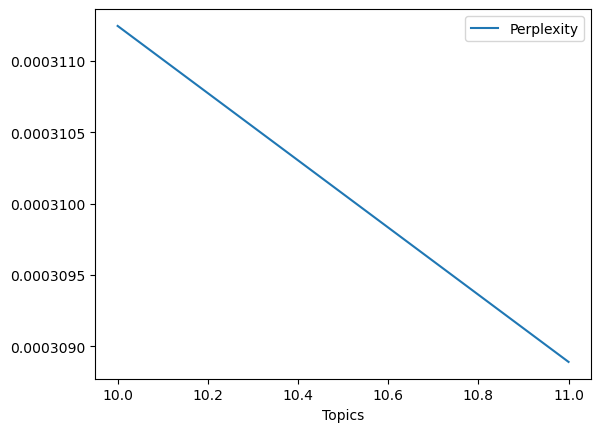

In [30]:
fig = dframe.plot(x ='Topics', y='Perplexity', kind='line').get_figure()
fig.savefig('perplexity_plot.pdf')

Lastly, the scores dataframe is saved to a csv.

In [31]:
dframe.to_csv('perplexity_scores.csv', index=False)

The above demonstrates that our grid search method works. We actually ran our grid search using the HPC with min_topics=10, max_topics = 60 and step_size = 2. Below is the perplexity plot outputted from the grid search. Please ignore the external axis, this is only used to scale the image.

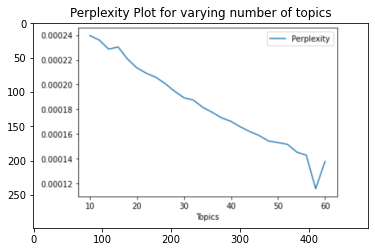

In [5]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("Perplexity Plot for varying number of topics")
 
image = mpimg.imread("Perplexity-Plot-for-tuning.png")
plt.imshow(image)

As there was no elbow in the plot, we decided to set the number of topics to 58 as this produced the lowest perplexity score. As we only ran our hyperparameter tuning on a small subset of the data, we recognise that the true optimal number of topics will be larger than 58, but this provides a good lower bound for our project. If we had more time, we would have performed cross validation as well as exploring a larger search space. 

We adapted this notebook for use on the HPC, in order to run on a larger dataset. This notebook has been ran with a smaller subset on Jupyter to demonstrate the output.